 <a name="begin"></a>

# Cross Selling via Association rules - Real company case

# Summary

1. [Importing libraries](#libraries)
2. [Importing data](#data)
3. [Shapping the Dataframe to a basket view](#shapping)
    1. [Example](#example)
    2. [Running for all product lines](#forall)
4. [Generating metrics for product association - Support and Confidence](#metrics)
    1. [Defining thresholds](#thresh)
5. [Generating the recommendations](#recommendations)
    1. [Getting the costumer basket](#basket)
        1. [Example](#example2)
        2. [Running for all clients](#forall2)
6. [Bonus – TOP sellers recommendation](#bonus)
    1. [Finding the top sellers](#topsell)


 <a name="libraries"></a>

## Importing libraries

[Back to top](#begin)

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import locale
import glob as glob
from itertools import combinations
from collections import Counter
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

 <a name="data"></a>

## Importing data
[Back to top](#begin)

In [2]:
# Using glob function to grab the name of all the files that start and finish with specified string
files = glob.glob('table_billing_*.xlsx')
# Effectively reading the tables with pandas
df_list = [pd.read_excel(files[i]) for i in range(len(files))]

# Importing the clients and sellers table
chave_vendedor = pd.read_excel('ClientesVendedor.xlsx')

In [3]:
# Concating the tables into a single dataframe
df = pd.concat(df_list)

# Renaming the columns
df.columns = ['MATERIAL_COD', 'MATERIAL_NOME', 'LINHA_PRODUTO',
       'STOCK_ORDER', 'CLIENTE_CORP_ID', 'CLIENTE_CORP_NOME',
       'CLIENTE_COMPLETO_ID', 'CLIENTE_COMPLETO_NOME', 'CLIENTE_COMPLETO_CIDADE', 'CLIENTE_COMPLETO_UF',
       'CLIENTE_COMPLETO_CEP', 'SEGMENTO', 'CANAL', 'MERCADO',
       'DATA', 'PERIODO', 'UNIDADES', 'CUSTO',
       'VENDAS', 'RESULTADO']

In [4]:
# Renaming the columns
chave_vendedor.columns = ['Clientes Status', 'CLIENTE_COMPLETO_ID', 'CLIENTE_COMPLETO_NOME', 'Nome_Fantasia',
       'CNPJ', 'CLIENTE_CORP_ID', 'CLIENTE_CORP_NOME', 'FILIAL_ID',
       'FILIAL', 'VENDEDOR_ID', 'VENDEDOR', 'SEGMENTO', 'CANAL']

# Getting only the needed columns
chave = chave_vendedor[['CLIENTE_COMPLETO_ID','CLIENTE_CORP_ID', 'SEGMENTO', 'VENDEDOR_ID']]

In [5]:
# Setting the locale variable
locale.setlocale(locale.LC_ALL, 'pt-BR.UTF-8')

# Cleaning the data with bad readings
# The UNIDADES column accounts for peaces sold and the RESULTADO column is the revenue from that sale
# If both are less or equal to zero, we don't want that
df = df.drop(df[(df.UNIDADES<=0) & (df.RESULTADO<=0)].index)

# Filtering only products that go to stock
df = df[df['STOCK_ORDER']=='MTS']
df = df[df['LINHA_PRODUTO']!='Sys. Compon.']

# Creating copies to be used
df2 = df.copy()
df3 = df.copy()

In [6]:
# Dataframe example
df.drop(['CLIENTE_CORP_NOME', 'CLIENTE_COMPLETO_NOME', 'CLIENTE_COMPLETO_CIDADE', 'CLIENTE_COMPLETO_UF', 'CLIENTE_COMPLETO_CEP'], axis=1).head(5)

,MATERIAL_COD,MATERIAL_NOME,LINHA_PRODUTO,STOCK_ORDER,CLIENTE_CORP_ID,CLIENTE_COMPLETO_ID,SEGMENTO,CANAL,MERCADO,DATA,PERIODO,UNIDADES,CUSTO,VENDAS,RESULTADO
0,5539500001,SHS SST 225x275 CAR01 CAR C60,Coated,MTS,20244030,20244030,Distribuição (Construção),Revend. Ferragista e Ferram.,Domestico,2019-01-18,Jan 19,1500.0,357.5895,491.74,134.1505
1,5539500001,SHS SST 225x275 CAR01 CAR C60,Coated,MTS,20244980,20244980,Distribuição (Construção),Loja de Tinta Imobiliária,Domestico,2019-02-05,Fev 19,500.0,119.1970,175.84,56.6430
2,5539500001,SHS SST 225x275 CAR01 CAR C60,Coated,MTS,20275231,20275231,Distribuição (Construção),Atacado Regional,Domestico,2019-01-30,Jan 19,500.0,119.1965,137.15,17.9535
4,5539500001,SHS SST 225x275 CAR01 CAR C60,Coated,MTS,20405950,20405950,Distribuição (Construção),Revend. Ferragista e Ferram.,Domestico,2018-12-31,Jan 19,1500.0,357.5895,478.37,120.7805
5,5539500001,SHS SST 225x275 CAR01 CAR C60,Coated,MTS,20429135,20429135,Distribuição (Construção),Atacado Regional,Domestico,2019-01-30,Jan 19,500.0,119.1965,169.06,49.8635


<a name="shapping"></a>

## Shapping the Dataframe to a basket view
[Back to top](#begin)

In [7]:
# First we replace every comma in the products column for dots
df2['MATERIAL_NOME'] = df2['MATERIAL_NOME'].apply(lambda x: x.replace(',','.'))

# Creating a copy of the products columns to assign as values in pivot function
df2['VALORES'] = df2['MATERIAL_NOME']

# Initiating a blank datafram
data = pd.DataFrame()

Important observation: Our dataframe is severily imbalanced in sales depending on the product's product line (see graph below). If we do not take that into account we are going to have a huge bias towards those product lines that sell much more.

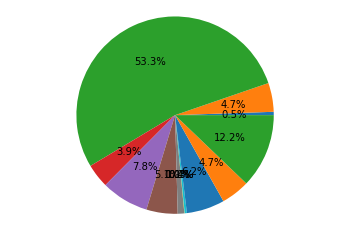

In [8]:
sizes = df2.groupby('LINHA_PRODUTO').LINHA_PRODUTO.count()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, autopct='%1.1f%%')
ax1.axis('equal')

plt.show()

 <a name="example"></a>

### Example
[Back to top](#begin)

For purposes of better understanding I am going to break the for loop to show the outputs of each step

In [9]:
line = 'TMA'
df = df2[df2['LINHA_PRODUTO']==line]

# Now I am pivoting out table so our index will be client ID and date configuring a basket
# The products are becoming the columns and also the values in those columns
# Whenever we get a duplicated register, we aggregate with a distinct separetor that will help clean this afterwards
pvt = pd.pivot_table(df.reset_index(), 
                     index=['CLIENTE_CORP_ID', 'CLIENTE_COMPLETO_ID', 'DATA','LINHA_PRODUTO'], columns='MATERIAL_NOME', 
                     values='VALORES', aggfunc=lambda x: '|* '.join(x)).reset_index()
pvt.head(5)

MATERIAL_NOME,CLIENTE_CORP_ID,CLIENTE_COMPLETO_ID,DATA,LINHA_PRODUTO,127MM BACK-UP TAPERED HIGHT NO HOLE BX5,16' X 400 FT PAINTABLE OVERSPRAY,18025 - DYN RED FOUR-IN-ONE VERSATILITY,18100 - DYN RED AUTO FILE II ABRAS BELT,"3"" BLUE FOAM PAD BX10","3"" LIQUID ICE WOOL PAD BX10",...,WHEELBRUSHCR D75X10X6 STEEL 030 BX10,WHEELBRUSHCR D75X13X6 STEEL 030 BX10,WIREBRUSH 1777 035 4X15 STEEL OSB BX12,WIREBRUSH 1780 STEEL 035 T25 OSB BX12,WOOL BUFF PAD 8” DOUBLE SIDE 6PC,"WOOL PAD 8"" - STEP1 LIQUID ICE BX6 IMP","WOOL POLISHING PAD DOUBLE FACE 8"" BX6-IM","WOOL POLISHING PAD VELCRO 8"" BOX6-IMP","WOOL SKIN WITH FEADER 5"" BX12",WOOLSYNTHETICPOLISHINGPADVELCRO 8 BX6IMP
0,20239530,20239530,2019-09-03,TMA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20239530,20239530,2020-04-22,TMA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20239530,20239530,2020-07-01,TMA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20239530,20239530,2020-09-21,TMA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20239531,20239531,2020-01-21,TMA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# So we turn all the product columns into a list
pvt['LISTA'] = pvt.drop(['CLIENTE_CORP_ID', 'CLIENTE_COMPLETO_ID', 'DATA','LINHA_PRODUTO'], axis =1).values.tolist()

# Now we get only out indexes and the list
pvt = pvt[['CLIENTE_CORP_ID', 'CLIENTE_COMPLETO_ID', 'DATA','LINHA_PRODUTO','LISTA']]

pvt.head(5)

MATERIAL_NOME,CLIENTE_CORP_ID,CLIENTE_COMPLETO_ID,DATA,LINHA_PRODUTO,LISTA
0,20239530,20239530,2019-09-03,TMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,20239530,20239530,2020-04-22,TMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
2,20239530,20239530,2020-07-01,TMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3,20239530,20239530,2020-09-21,TMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,20239531,20239531,2020-01-21,TMA,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


In [11]:
# So every time the client did not purchased that product on that date we get a nan value, so we have to clean those
pvt['LISTA'] = pvt['LISTA'].apply(lambda x: [i for i in x if str(i) != "nan"])

# And we also have to remove the aggregated products
pvt['LISTA'] = pvt['LISTA'].apply(lambda x: [i.split('|* ')[0] for i in x])

pvt.head(5)

MATERIAL_NOME,CLIENTE_CORP_ID,CLIENTE_COMPLETO_ID,DATA,LINHA_PRODUTO,LISTA
0,20239530,20239530,2019-09-03,TMA,[WHEELBRUSHCR D250X25D100STEEL 040 OSBBX6]
1,20239530,20239530,2020-04-22,TMA,[BUCHA TELESCOPICA 31.75-12.7 NORTON CX10]
2,20239530,20239530,2020-07-01,TMA,[BUCHA TELESCOPICA 31.75-12.7 NORTON CX10]
3,20239530,20239530,2020-09-21,TMA,[BUCHA TELESCOPICA 31.75-12.7 NORTON CX10]
4,20239531,20239531,2020-01-21,TMA,[WHEEL BLADE WOOD CAR 110X1X20MM BX10]


 <a name="forall"></a>

### Running for all product lines
[Back to top](#begin)

In [12]:
# Creating a basket datafram for each product line
for linha in df2.LINHA_PRODUTO.unique():
    
    #Creating a temporary dataframe with the current product line
    df = df2[df2['LINHA_PRODUTO']==linha]
    pvt = pd.pivot_table(df.reset_index(), index=['CLIENTE_CORP_ID', 'CLIENTE_COMPLETO_ID', 'DATA','LINHA_PRODUTO'], columns='MATERIAL_NOME', values='VALORES', aggfunc=lambda x: '|* '.join(x)).reset_index()
    pvt['LISTA'] = pvt.drop(['CLIENTE_CORP_ID', 'CLIENTE_COMPLETO_ID', 'DATA','LINHA_PRODUTO'], axis =1).values.tolist()
    pvt = pvt[['CLIENTE_CORP_ID', 'CLIENTE_COMPLETO_ID', 'DATA','LINHA_PRODUTO','LISTA']]
    pvt['LISTA'] = pvt['LISTA'].apply(lambda x: [i for i in x if str(i) != "nan"])
    pvt['LISTA'] = pvt['LISTA'].apply(lambda x: [i.split('|* ')[0] for i in x])
    data = data.append(pvt)

 <a name="metrics"></a>

## Generating metrics for product association - Support and Confidence
[Back to top](#begin)

Support - It measures how many times the product have been bought. In other words, how often does it appears in the 
costumer basket.

Confidence - It measures the likelihood of a product B being purchase given that a product A was purchased.

In [13]:
# Initiating blank datafram
data2 = pd.DataFrame()

# Just like the basket data set the metrics have to be calculated separatly for each product line
for linha in data.LINHA_PRODUTO.unique():
    df = data[data['LINHA_PRODUTO']==linha]
    
    # Initiating a counter
    count = Counter()
    
    # For every row in the DF
    for row in df['LISTA']:
        # Get the list on that row
        row_list = row
        
        # The counter is going to update on every combination of two string on each row
        count.update(Counter(combinations(row_list,2)))
    
    # Transforming the dict into a dataframe
    df2 = pd.DataFrame.from_dict(count, orient='index').reset_index()
    # The dataframe has two columns the RULE (a string with the products) and the COUNT
    
    # Renaming the columns
    df2.columns = ['REGRA', 'SUPORTE_AB']
    
    # Creating a Suport metric by percentage (that takes into account the size of the dataframe)
    df2['SUPORTE_AB_PERCENT'] = df2['SUPORTE_AB'] / df.shape[0]
    # Separating the RULE column into Material A and Material B
    df2[['MATERIAL_A','MATERIAL_B']] = pd.DataFrame(df2.REGRA.tolist(), index= df2.index)
    
    # Reseting the counter
    count = Counter()

    # Doing the same thing as before, but counting the appereance of each product alone.
    # We are going to need that to calculate the confidence
    for row in df['LISTA']:
        row_list = row
        count.update(Counter(combinations(row_list,1)))
        
    df_sup = pd.DataFrame.from_dict(count, orient='index').reset_index()

    df_sup.columns = ['MATERIAL_A', 'SUPORTE_A']
    df_sup[['MATERIAL_A']] = pd.DataFrame(df_sup.MATERIAL_A.tolist(), index= df_sup.index)
    
    
    df_sup['SUPORTE_A_PERCENT'] = df_sup['SUPORTE_A'] / df.shape[0]
    
    df2['MATERIAL_A'] = df2['MATERIAL_A'].astype(str)
    df2['MATERIAL_B'] = df2['MATERIAL_B'].astype(str)
    df_sup['MATERIAL_A'] = df_sup['MATERIAL_A'].astype(str)

    # Merging the dataframs with the rule's suport and the product alone suport
    df = pd.merge(df2, df_sup, on='MATERIAL_A', how='left')
    # Droping duplicates where we have the same combination on either side
    df = df.drop_duplicates(['MATERIAL_A','MATERIAL_B','REGRA'])
    
    # Calculating the confidence
    # The confidence is the number of times both products have been bought together divided by all the purchases of
    # only product A
    df['CONFIANCA_A'] = df['SUPORTE_AB'] / df['SUPORTE_A']
    
    # Getting the information of the product line
    df['LINHA_PRODUTO'] = linha

    data2 = data2.append(df)

In [14]:
data2.head(5)

,REGRA,SUPORTE_AB,SUPORTE_AB_PERCENT,MATERIAL_A,MATERIAL_B,SUPORTE_A,SUPORTE_A_PERCENT,CONFIANCA_A,LINHA_PRODUTO
0,"(SHS SST 225x275 A219 NOR C150, SHS SST 225x27...",112,0.001143,SHS SST 225x275 A219 NOR C150,SHS SST 225x275 A219 NOR C400,1080,0.01102,0.103704,Coated
1,"(SHS SST 225x275 A219 NOR C150, SHS SST 225x27...",137,0.001398,SHS SST 225x275 A219 NOR C150,SHS SST 225x275 A257 NOR C50,1080,0.01102,0.126852,Coated
2,"(SHS SST 225x275 A219 NOR C150, SHS SST 225x27...",204,0.002082,SHS SST 225x275 A219 NOR C150,SHS SST 225x275 A257 NOR C80,1080,0.01102,0.188889,Coated
3,"(SHS SST 225x275 A219 NOR C150, SHS SST 225x27...",299,0.003051,SHS SST 225x275 A219 NOR C150,SHS SST 225x275 K246 NOR C100,1080,0.01102,0.276852,Coated
4,"(SHS SST 225x275 A219 NOR C150, SHS SST 225x27...",227,0.002316,SHS SST 225x275 A219 NOR C150,SHS SST 225x275 K246 NOR C220,1080,0.01102,0.210185,Coated


 <a name="thresh"></a>

### Defining thresholds
[Back to top](#begin)

Based on a business view we defined the minimum values for suport and confidence to generate a recomendation

In [15]:
# Suport was defined as 1% of the total data frame
# The product must have been bought at least in 1% of all purchases
suport = 0.01

# Confidence was defined as 50%
# Both products must have been bought together 50% of the time that product A was bought
confidence = 0.5

In [16]:
dt = data2[(data2['SUPORTE_A_PERCENT']>=suport)&(data2['CONFIANCA_A']>=confidence)]

 <a name="recommendations"></a>

## Generating the recommendations
[Back to top](#begin)

 <a name="basket"></a>

### Getting the costumer basket

In [17]:
# Dynamically selecting the date of one year ago
lastyear = (datetime.today() - relativedelta(years=1)).strftime('%Y-%m-%d')

In [18]:
# Filtering the dataframe to get only the last year purchases 
df3 = df3[df3['DATA']>=lastyear]

In [19]:
# Dropping the duplicates of products for each client
# Our goal here is to get the products that have been bought regardless of how many times
df3 = df3[['CLIENTE_COMPLETO_ID','MATERIAL_NOME']].drop_duplicates()

 <a name="example2"></a>

#### Example
[Back to top](#begin)

For purposes of better understanding I am going to break the for loop to show the outputs of each step

In [20]:
cliente = 20468956

# The first step with filter for the current client on the loop
# And turn all the products that he has bought into a list
cesta = df3['MATERIAL_NOME'][df3['CLIENTE_COMPLETO_ID']==cliente].tolist()
set(cesta)

{'SHS SST 225x275 CAR01 CAR C100',
 'SHS SST 225x275 CAR01 CAR C120',
 'SHS SST 225x275 CAR01 CAR C150',
 'SHS SST 225x275 CAR01 CAR C180',
 'SHS SST 225x275 CAR01 CAR C220',
 'SHS SST 225x275 CAR01 CAR C60',
 'SHS SST 225x275 CAR03 CAR C120',
 'SHS SST 225x275 CAR03 CAR C150',
 'SHS SST 225x275 CAR15 CAR C150',
 'SHS SST 225x275 CAR41 CAR C80'}

In [21]:
# Now we have to confront the list of products purchased by the client with our dataframe of association
# So if the client buys the product A we want to suggest product B
# At the same time, maybe the client already buys the product B, so that is not a valid suggestion
# Filtering the DF for every product that is in the client's basket
# At the same time, droping the suggestion of products the client already buys
rec = dt[(dt['MATERIAL_A'].isin(cesta))&(~dt['MATERIAL_B'].isin(cesta))]
rec.head(3)

,REGRA,SUPORTE_AB,SUPORTE_AB_PERCENT,MATERIAL_A,MATERIAL_B,SUPORTE_A,SUPORTE_A_PERCENT,CONFIANCA_A,LINHA_PRODUTO
882,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",699,0.007133,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C180,1281,0.013071,0.545667,Coated
1055,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",666,0.006796,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C220,1281,0.013071,0.519906,Coated


In [22]:
# Sorting the recomendations by the confidence
rec = rec.sort_values(by='CONFIANCA_A', ascending=False, ignore_index=True)

# Droping duplicates of product B, so we won't recommend the same product twice
rec = rec.drop_duplicates(subset='MATERIAL_B', keep='first', ignore_index=True)

# Them we get the top 5 products (We do 5 so we won't over recomend products at once)
rec.head(5)

,REGRA,SUPORTE_AB,SUPORTE_AB_PERCENT,MATERIAL_A,MATERIAL_B,SUPORTE_A,SUPORTE_A_PERCENT,CONFIANCA_A,LINHA_PRODUTO
0,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",699,0.007133,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C180,1281,0.013071,0.545667,Coated
1,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",666,0.006796,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C220,1281,0.013071,0.519906,Coated


 <a name="forall2"></a>

#### Running for all clients
[Back to top](#begin)

In [23]:
# Initiating a blank dataframe
sug_pessoal = pd.DataFrame()

for cliente in df3.CLIENTE_COMPLETO_ID.unique():
    cesta = set(df3['MATERIAL_NOME'][df3['CLIENTE_COMPLETO_ID']==cliente].tolist())
    rec = dt[(dt['MATERIAL_A'].isin(cesta))&(~dt['MATERIAL_B'].isin(cesta))]
    rec = rec.sort_values(by='CONFIANCA_A', ascending=False, ignore_index=True)
    rec = rec.drop_duplicates(subset='MATERIAL_B', keep='first', ignore_index=True)
    rec = rec.head(5)
    rec['CLIENTE_COMPLETO_ID'] = cliente
    sug_pessoal = sug_pessoal.append(rec)

In [24]:
sug_pessoal.head(3)

,REGRA,SUPORTE_AB,SUPORTE_AB_PERCENT,MATERIAL_A,MATERIAL_B,SUPORTE_A,SUPORTE_A_PERCENT,CONFIANCA_A,LINHA_PRODUTO,CLIENTE_COMPLETO_ID
0,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",699,0.007133,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C180,1281,0.013071,0.545667,Coated,20468956
1,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",666,0.006796,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C220,1281,0.013071,0.519906,Coated,20468956
0,"(SHS SST 225x275 CAR03 CAR C150, SHS SST 225x2...",699,0.007133,SHS SST 225x275 CAR03 CAR C150,SHS SST 225x275 CAR03 CAR C180,1281,0.013071,0.545667,Coated,20244955


 <a name="bonus"></a>

# Bonus
[Back to top](#begin)

# TOP sellers recomendation

 <a name="topsell"></a>

## Finding the top sellers

In [25]:
# Defining the basket size
basket_size = 5
# Initiating blank datafram
sug_topsell = pd.DataFrame()

# For each product line
for linha in dt.LINHA_PRODUTO.unique():
    # Filer for the current product line
    topsell = dt[dt['LINHA_PRODUTO']==linha]
    # Sort the product by its suport (how many time it has been bought)
    topsell = topsell.sort_values(by='SUPORTE_A')
    # Get the first X products
    topsell = topsell.head(basket_size)
        
        
    # Making the recomendation for each client with each product line
        
        
    for cliente in df3.CLIENTE_COMPLETO_ID.unique():
        # Creating a list of products this client has purchased
        cesta = df3['MATERIAL_NOME'][df3['CLIENTE_COMPLETO_ID']==cliente].tolist()
        # Sellecting the products that are not in the client basket
        rec = topsell[~topsell['MATERIAL_A'].isin(cesta)]
        # Defining a score of attendance of the top sellers basket
        rec['SCORE'] = 1 - (rec.shape[0] / basket_size)
        rec['CLIENTE_COMPLETO_ID'] = cliente
        sug_topsell = sug_topsell.append(rec)

In [26]:
sug_topsell.head(3)

,REGRA,SUPORTE_AB,SUPORTE_AB_PERCENT,MATERIAL_A,MATERIAL_B,SUPORTE_A,SUPORTE_A_PERCENT,CONFIANCA_A,LINHA_PRODUTO,SCORE,CLIENTE_COMPLETO_ID
699,"(SHS SST 225x275 CAR41 CAR C40, SHS SST 225x27...",509,0.005194,SHS SST 225x275 CAR41 CAR C40,SHS SST 225x275 CAR41 CAR C80,996,0.010163,0.511044,Coated,0.0,20244527
6908,"(SHS SST 230x280 T216 NOR C220, SHS SST 230x28...",553,0.005643,SHS SST 230x280 T216 NOR C220,SHS SST 230x280 T216 NOR C320,1044,0.010653,0.529693,Coated,0.0,20244527
6121,"(SHS SST 230x280 T216 NOR C220, SHS SST 230x28...",563,0.005745,SHS SST 230x280 T216 NOR C220,SHS SST 230x280 T216 NOR C400,1044,0.010653,0.539272,Coated,0.0,20244527
